### Read csv file and create data frame

In [2]:
%env CUDA_VISIBLE_DEVICES 0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
import random
import sys
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.manifold import TSNE
from CDR.hdgcn.HDGCN import Model
from feeders.feeder_ntu import Feeder
from graph.ntu_rgb_d_hierarchy import Graph

model_path = '/cvhci/temp/prgc/hdgcn_filtered/work_dir_40/ntu_hdgcn/cross-view/bone_CoM_1/runs-50-24250.pt'

# load dataset
def load_data():
    test_data_path="/cvhci/temp/prgc/hdgcn_filtered/origin/no_noise/noisy_dataset/NTU60_CV.npz"
    #test_label_path="/cvhci/temp/prgc/st-gcn/data/clean/xview/test_label.pkl"

    test_dataset = Feeder(data_path=test_data_path,split= 'test', window_size=16, p_interval=[0.95], bone= False, debug=False)

    return test_dataset

def init_seed(seed):
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Evaluate the Model
def evaluate(test_loader, model1):
    model1.eval()  # Change model to 'eval' mode.
    # correct1 = 0
    # total1 = 0
    results = []
    labels = []
    print(test_loader)
    with torch.no_grad():
        for data, label, _ in test_loader:
            data = data.cuda()
            logits1 = model1(data)
            results.append(logits1['logits'].cpu().numpy())
            labels.append(label.cpu().numpy())
    
    return np.concatenate(results), np.concatenate(labels)
            
    #         outputs1 = F.softmax(logits1, dim=1)
    #         _, pred1 = torch.max(outputs1.data, 1)
    #         total1 += labels.size(0)
    #         correct1 += (pred1.cpu() == labels.long()).sum()

    #     acc1 = 100 * float(correct1) / float(total1)

    # return acc1
    

model = Model(graph=Graph(labeling_mode= 'spatial',CoM=1),compute_flops= True)
model.load_state_dict(torch.load(model_path))
model.fcn = nn.Sequential()
model.cuda()

test_loader = torch.utils.data.DataLoader(dataset=load_data(),
                                            batch_size=16,
                                            num_workers=3,
                                            drop_last=False,
                                            shuffle=False,
                                            worker_init_fn=init_seed)

results, labels = evaluate(test_loader, model)

/home/prgc/acrionreco-with-noisy-data-topic-c/env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
results = np.array(object=results, dtype=np.float32)

### Plot 2D t-SNE

In [5]:
tsne = TSNE(n_components=2, random_state=123, n_iter=1000).fit_transform(results)

In [6]:
data = np.vstack((tsne.T, labels)).T 
print(data.shape)
df_tsne = pd.DataFrame(data, columns=['dim1', 'dim2', 'label']) 
df_tsne.head()

(3882, 3)


,dim1,dim2,label
0,-11.993055,57.421982,15.0
1,-17.775309,-14.935406,12.0
2,9.359408,53.864300,34.0
3,24.646879,-18.012672,1.0
4,-52.873413,48.557613,54.0


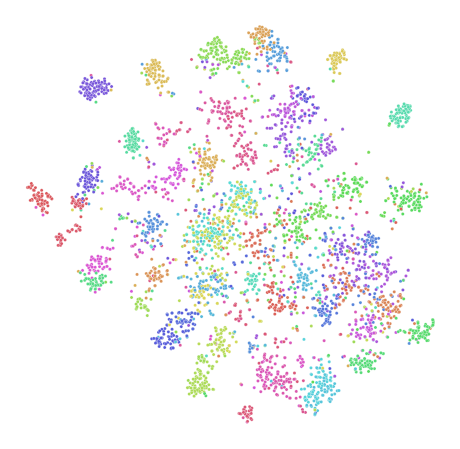

In [7]:
plt.figure(figsize=(8, 8)) 
sns.scatterplot(data=df_tsne, hue='label', palette=sns.color_palette("hls", 60), s=10, legend=False, x='dim1', y='dim2') 
plt.axis('off')
# plt.show()
plt.savefig(model_path.split(".")[0] + "_2d_2.png", dpi=300, bbox_inches='tight')

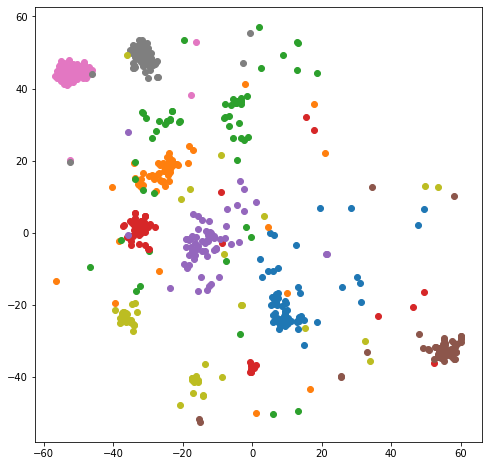

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

x = df_tsne['dim1']
y = df_tsne['dim2']
# z = df_tsne_3d['dim3']
i = df_tsne['label']

for s in i.unique():
    if s % 7 == 0:
        ax.scatter(x[i==s],y[i==s],label=int(s))
# ax.legend()
# plt.axis('off')

### Plot 3D t-SNE

In [9]:
tsne_3d = TSNE(n_components=3, random_state=123, n_iter=2000).fit_transform(results)

In [10]:
data_3d = np.vstack((tsne_3d.T, labels)).T 
print(data_3d.shape)
df_tsne_3d = pd.DataFrame(data_3d, columns=['dim1', 'dim2', 'dim3', 'label']) 
df_tsne_3d.head()

(3882, 4)


,dim1,dim2,dim3,label
0,-27.448256,9.270001,3.248081,15.0
1,1.708187,17.699486,-6.685533,12.0
2,-25.405195,-5.518394,-4.230852,34.0
3,2.730999,-20.078743,-0.723429,1.0
4,-7.800322,23.490536,-5.941326,54.0


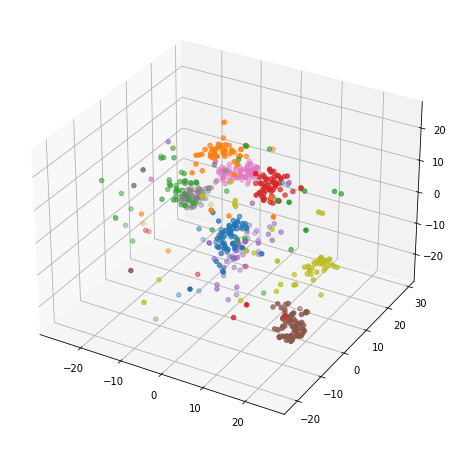

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

x = df_tsne_3d['dim1']
y = df_tsne_3d['dim2']
z = df_tsne_3d['dim3']
i = df_tsne_3d['label']

for s in i.unique():
    if s % 1 == 0:
        ax.scatter(x[i==s],y[i==s],z[i==s],label=int(s), s=5, depthshade=True)
plt.savefig(model_path.split(".")[0] + "_3d_1.png", dpi=900, bbox_inches='tight')
# ax.legend()